In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from wikidata import WikidataClient
from wikidata.queries import *
from utils.numbers import round_number

%matplotlib widget

In [ ]:
# Our proprietary client for Wikidata
wiki = WikidataClient()

In [ ]:
# Run the predefined SPARQL queries to fetch data
municipalities = wiki.execute_query(SPARQL_MUNICIPALITIES)
peaks = wiki.execute_query(SPARQL_PEAKS)
castles = wiki.execute_query(SPARQL_CASTLES)

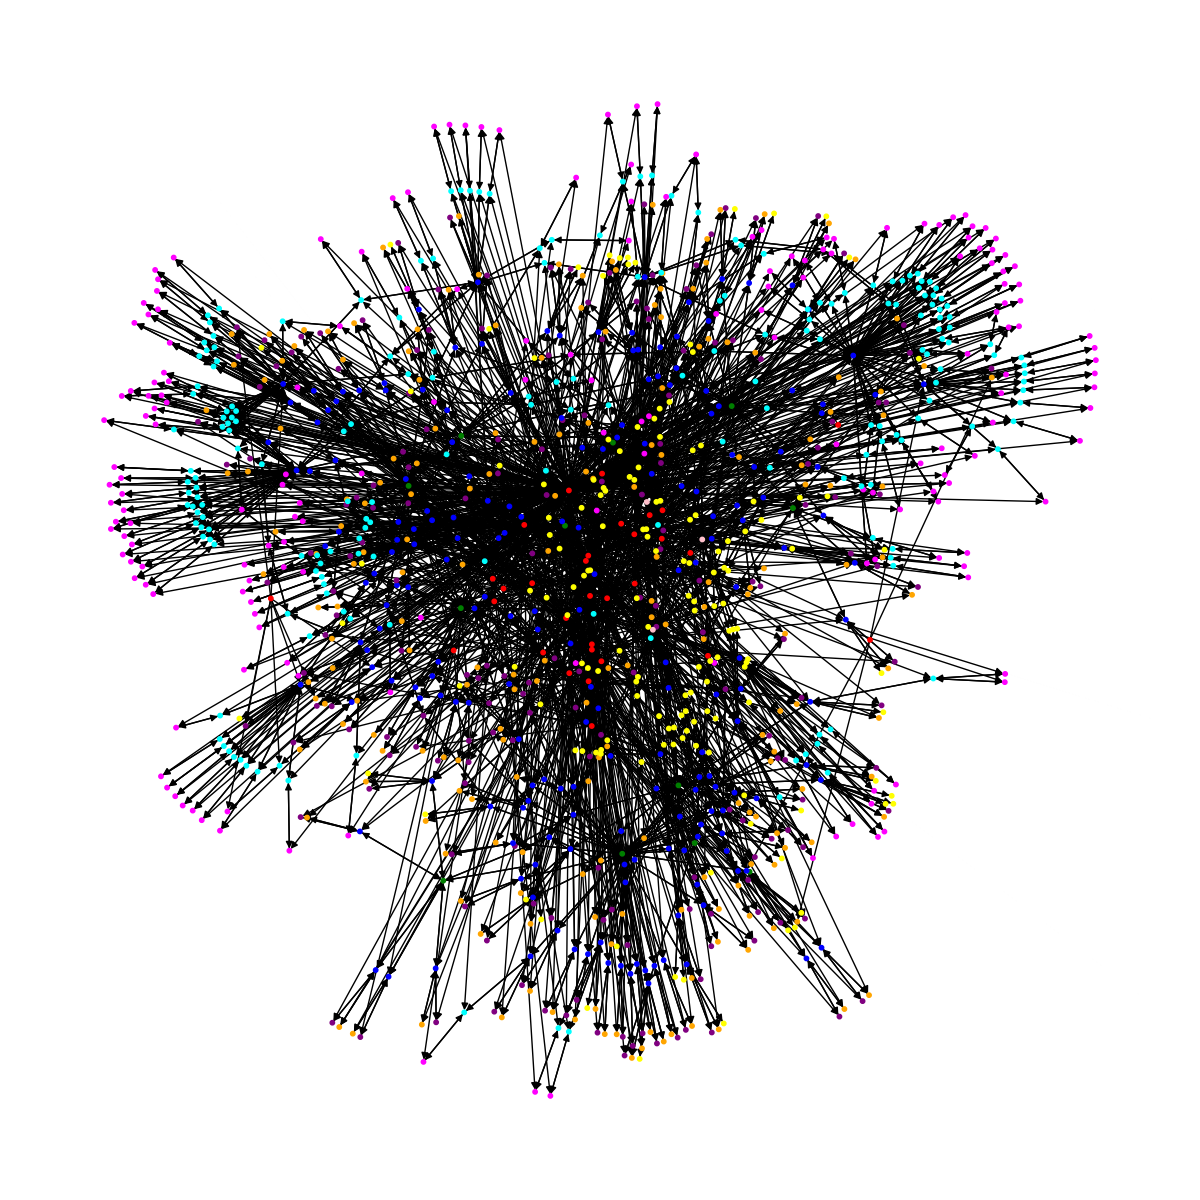

In [ ]:
# Create a directed graph
graph = nx.DiGraph()

# Iterate over municipalities data
for _, row in municipalities.iterrows():
	# Add nodes and edges for municipalities and regions
	graph.add_node(row["municipality"], type="občina", label=row["municipalityLabel"])
	graph.add_node(row["region"], type="regija", label=row["regionLabel"])
	graph.add_edge(row["municipality"], row["region"], type="se_nahaja_v")
	graph.add_edge(row["region"], row["municipality"], type="ima_občino")

	# Check if population data is available
	if not np.isnan(row["population"]):
		# Get an approximate population value
		rounded_population = round_number(row["population"])
		# Add nodes and edges for population
		graph.add_node(f"~{rounded_population}", type="približno_število", label=str(rounded_population))
		graph.add_node(str(row["population"]), type="populacija", label=str(row["population"]))
		graph.add_edge(f"~{rounded_population}", str(row["population"]), type="je_približno")
		graph.add_edge(row["municipality"], str(row["population"]), type="ima_populacijo")
		graph.add_edge(f"~{rounded_population}", row["municipality"], type="je_približna_populacija_občine")
		graph.add_edge(str(row["population"]), row["municipality"], type="je_populacija_občine")

	# Check if area data is available
	if not np.isnan(row["area"]):
		# Get an approximate area value
		rounded_area = round_number(row["area"])
		# Add nodes and edges for area
		graph.add_node(f"~{rounded_area}", type="približno_število", label=str(rounded_area))
		graph.add_node(str(row["area"]), type="površina", label=str(row["area"]))
		graph.add_edge(f"~{rounded_area}", str(row["area"]), type="je_približno")
		graph.add_edge(row["municipality"], str(row["area"]), type="ima_površino")
		graph.add_edge(f"~{rounded_area}", row["municipality"], type="je_približna_površina_občine")
		graph.add_edge(str(row["area"]), row["municipality"], type="je_površina_občine")

# Iterate over peaks data
for _, row in peaks.iterrows():
	# Sanity check
	if row["adminEntity"] not in graph.nodes:
		continue

	# Add nodes and edges for peaks
	graph.add_node(row["peak"], type="vrh", label=row["peakLabel"])
	graph.add_edge(row["peak"], row["adminEntity"], type="se_nahaja_v")
	graph.add_edge(row["adminEntity"], row["peak"], type="ima_vrh")

	# Check if elevation data is available
	if not np.isnan(row["elevation"]):
		# Get an approximate elevation value
		rounded_elevation = round_number(row["elevation"])
		# Add nodes and edges for elevation
		graph.add_node(f"~{rounded_elevation}", type="približno_število", label=str(rounded_elevation))
		graph.add_node(str(row["elevation"]), type="višina", label=str(row["elevation"]))
		graph.add_edge(f"~{rounded_elevation}", str(row["elevation"]), type="je_približno")
		graph.add_edge(row["peak"], str(row["elevation"]), type="ima_višino")
		graph.add_edge(f"~{rounded_elevation}", row["peak"], type="je_približna_višina_vrha")
		graph.add_edge(str(row["elevation"]), row["peak"], type="je_višina_vrha")

# Iterate over castles data
for _, row in castles.iterrows():
	# Sanity check
	if row["adminEntity"] not in graph.nodes:
		continue

	# Add nodes and edges for castles
	graph.add_node(row["castle"], type="grad", label=row["castleLabel"])
	graph.add_edge(row["castle"], row["adminEntity"], type="se_nahaja_v")
	graph.add_edge(row["adminEntity"], row["castle"], type="ima_grad")

	# Check if heritage data is available
	if row["heritage"] != "":
		# Add nodes and edges for heritage
		graph.add_node(row["heritage"], type="dediščina", label=row["heritageLabel"])
		graph.add_edge(row["castle"], row["heritage"], type="pripada_dediščini")
		graph.add_edge(row["heritage"], row["castle"], type="ima_grad")

# Function to get node color based on type
def get_node_color(node_type):
	node_colors = {
		"občina": "blue",
		"regija": "green",
		"populacija": "orange",
		"površina": "purple",
		"približno_število": "red",
		"vrh": "cyan",
		"višina": "magenta",
		"grad": "yellow",
		"dediščina": "pink"
	}
	return node_colors.get(node_type, "gray")

# Draw the graph using NetworkX and Matplotlib
graph_pos = nx.spring_layout(graph, seed=42)
node_colors = [get_node_color(graph.nodes[node]["type"]) for node in graph.nodes()]

plt.figure(figsize=(12, 12))
nx.draw(graph, graph_pos, with_labels=False, node_size=10, node_color=node_colors, font_size=10)
plt.show()

In [ ]:
# Save the graph to a GraphML file
nx.write_graphml(graph, "../data/municipalities_peaks_castles.graphml")